In [1]:
# ========
# Packages
# ========

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

# Determine current working directory
cwd = os.getcwd()


In [2]:
# =========
# Constants
# =========

h = 6.6260755e-27     # Planck's constant (cm2 g-1 s-1)
c = 2.99792458e10     # Speed of light (cm s-1)
k = 1.380658e-16      # Boltzmann's constant (cm2 g s-2 K-1)
t_sun = 5778.0        # Temperature of the Sun (K)
d_sun = 1.3914e6      # Diameter of the Sun (km)
l_sun = 3.839e33      # Luminosity of the Sun (erg s-1)
sigma = 5.6704e-5     # Stefan-Boltzmann constant (g s-3 K-4)
conv = 1.496e8        # Number of km in an au
epsilon = 0.9         # Emissivity factor (dimensionless)
eta = 0.756           # Beaming parameter (dimensionless)


In [3]:
# ====================
# Function definitions
# ====================

# Define angular radius function
# Inputs: diameter (km), distance (au)
# Output: angular radius (radians)
def ang_rad(d, r):
    return d/(2.0*conv*r)

# Define Planck function in wavelength space
# Inputs: temperature (K), wavelength array (cm)
# Output: Planck function array (erg s-1 cm-3 sr-1)
def bb(t, lam):
    return (2.0*h*c**2/lam**5)*(1.0/(np.exp(h*c/(lam*k*t)) - 1.0))
    
# Define Bond albedo function using the empirical relation from Brucker et al. (2009)
#     involving the geometric albedo
# Inputs: visible geometric albedo (dimensionless)
# Output: Bond albedo (dimensionless)
def bond(p):
    return p*0.39

# Define reflected flux density function
# Accounts for the raditaion from the Sun incident on the body at its orbital distance,
#     then reflected to the observer given its Bond albedo to determine the reflected flux density
# Inputs: Bond albedo (dimensionless), Planck function array (erg s-1 cm-3 sr-1),
#     angular radius of the Sun seen from the object (radians), angular radius of the object as seen
#     by the observer (radians)
# Output: reflected flux density array (erg s-1 cm-3)
def flux_dens_refl(pv, bb, theta1, theta2):
    return np.pi*pv*bb*theta1**2*theta2**2

# Define thermal flux density function
# Calculates the temperature in concentric rings centered on the sub-solar point and adds the
#     contributions of all those rings for the final determination of the thermal flux density
# Assumes a fixed beaming parameter of 0.756 (that of Ceres) for the standard thermal model (STM)
# Assumes an emissivity factor of 0.9 (typical assumed value in absence of other information)
# Inputs: Bond albedo (dimensionless), heliocentric distance (au), angular radius (radians), wavelength array (cm)
# Output: flux density array (erg s-1 cm-3)
def flux_dens_thermal(a, r, theta, lam):
    sl = lam.size
    flux_stm = np.zeros(sl)
  
    nmu=100
    mu_stm=(np.arange(nmu) + 0.5)/float(nmu)
    da_stm=2.0*mu_stm/float(nmu)
    temp_stm=((l_sun*(1.0 - a)*mu_stm)/(4.0*np.pi*eta*sigma*epsilon*(1.0e5*conv*r)**2))**0.25
    temp_stm = np.array(temp_stm, dtype = np.float128)
    for i in range(nmu):
        flux_stm += da_stm[i]*bb(temp_stm[i], lam)
  
    return np.pi*flux_stm*theta**2


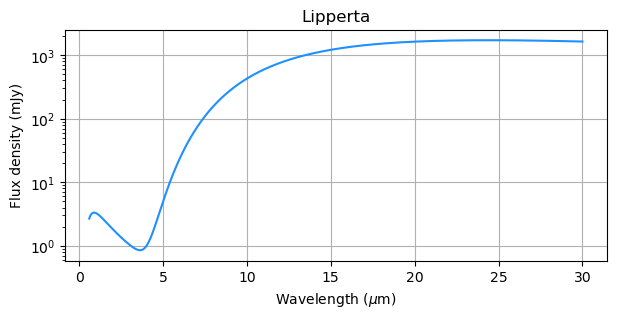

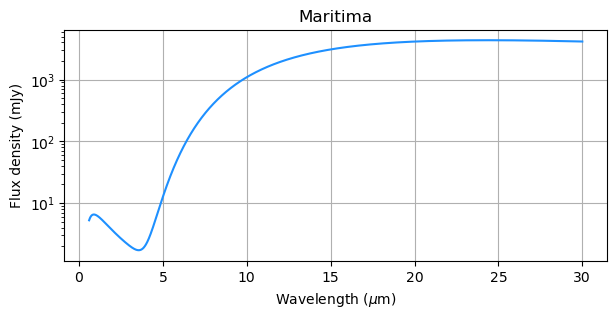

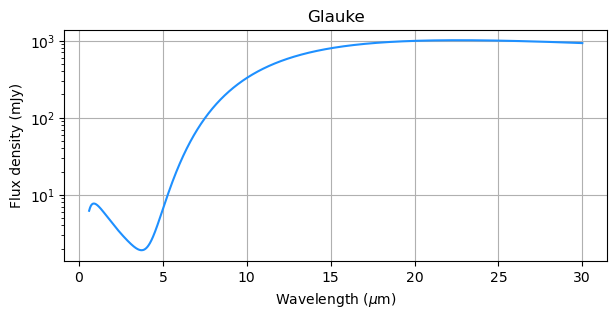

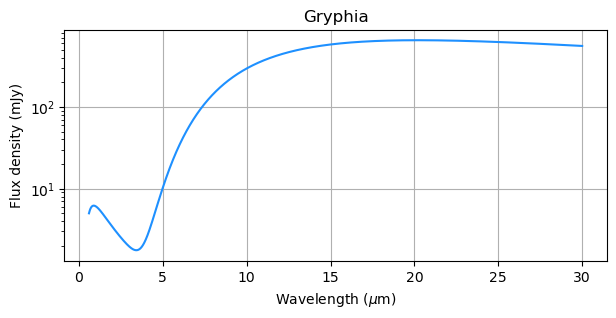

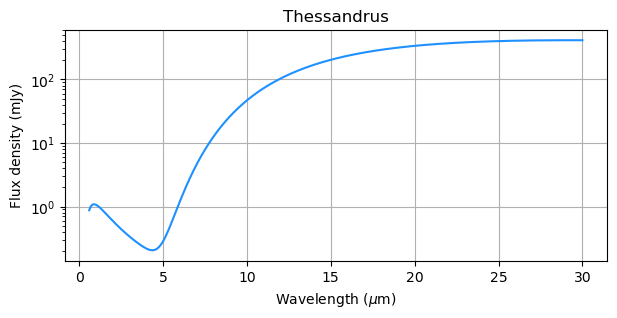

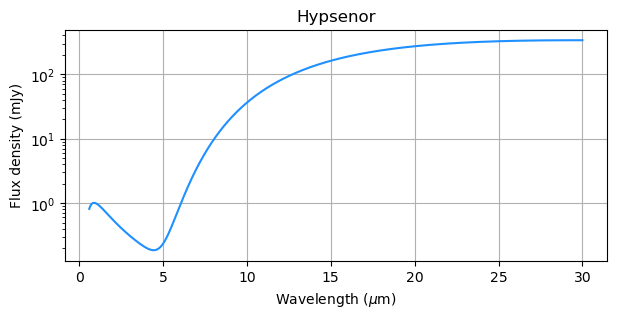

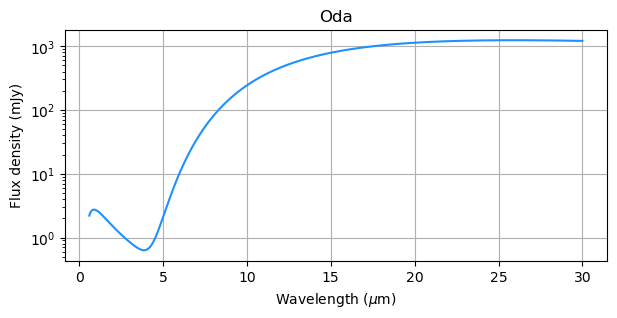

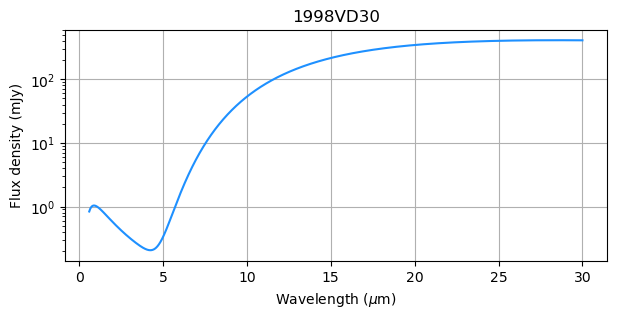

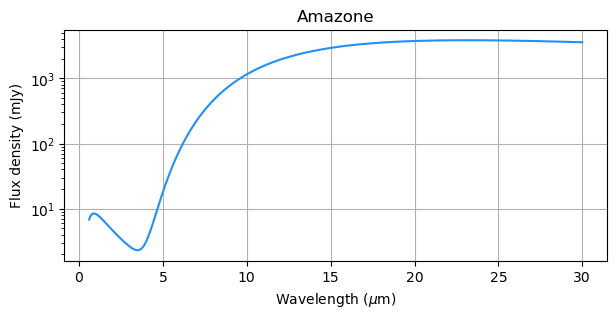

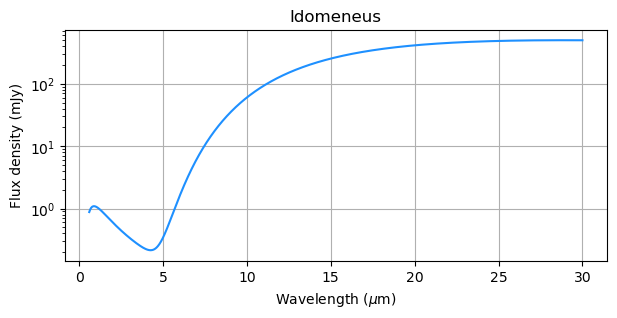

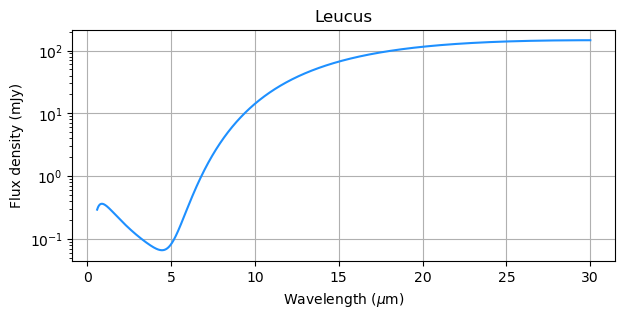

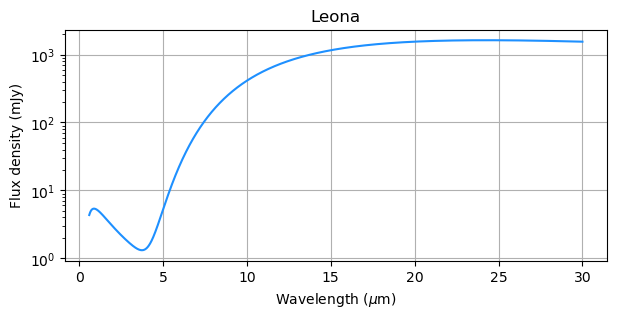

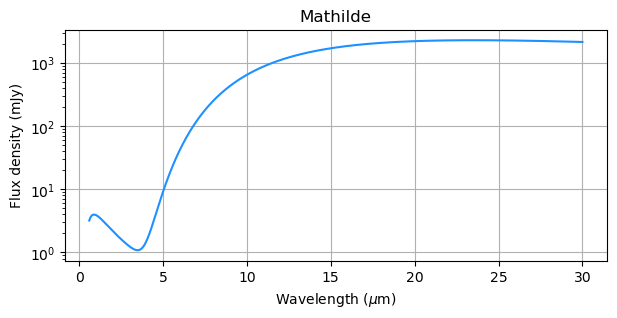

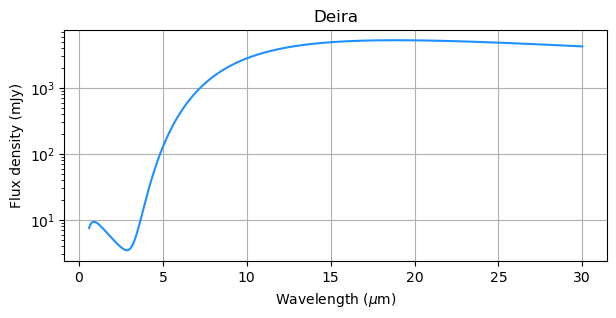

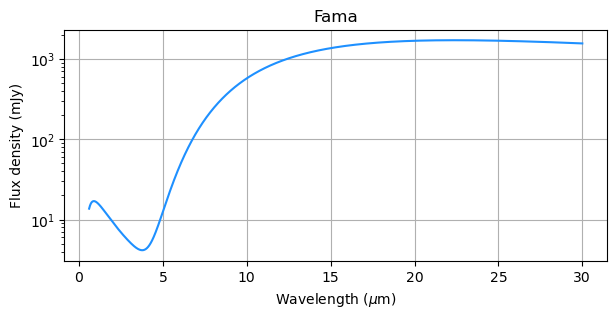

In [4]:
# ========================
# Calculate thermal models
# ========================

# Define target parameters
name = ['Lipperta', 'Maritima', 'Glauke', 'Gryphia', 'Thessandrus', 'Hypsenor', 'Oda', '1998VD30', 'Amazone', 'Idomeneus', 'Leucus', 'Leona', 'Mathilde', 'Deira', 'Fama']
d_targ = [52.41, 82.675, 28.981, 14.403, 51.263, 47.731, 56.337, 46.001, 63.920, 53.676, 34.155, 49.943, 52.8, 31.799, 35.620]
pv = [0.0506, 0.039, 0.175, 0.193, 0.081, 0.093, 0.061, 0.076, 0.054, 0.067, 0.079, 0.085, 0.0436, 0.036, 0.221]
r = [3.53, 3.52, 2.96, 2.35, 5.05, 5.14, 3.98, 4.78, 3.18, 4.93, 5.37, 3.47, 3.29, 2.12, 2.87]
delta = [3.05, 3.03, 2.46, 1.80, 4.62, 4.69, 3.52, 4.34, 2.68, 4.49, 4.95, 3.01, 2.80, 1.55, 2.36]

# Construct the wavelength array in microns, then convert to cm
# Default wavelength array: 0.5 - 30 um, 0.01 um intervals
lam_um = np.linspace(0.6, 30.0, 2941)
lam_cm = lam_um/10000.0

# Loop over the targets
for i in range(len(name)):

    # Calculate solar Planck function
    bb_sol = bb(t_sun, lam_cm)

    # Calculate angular radius of the Sun as seen at the
    #     heliocentric distance of the object
    theta_sun = ang_rad(d_sun, r[i])

    # Calculate the Bond albedo of the object
    a = bond(pv[i])

    # Calculate angular radius of the object as seen by the observer
    theta_targ = ang_rad(d_targ[i], delta[i])

    # Calculate reflected flux density
    s_refl = flux_dens_refl(pv[i], bb_sol, theta_sun, theta_targ)

    # Calculate thermal flux density
    s_thermal = flux_dens_thermal(a, r[i], theta_targ, lam_cm)

    # Calculate total flux density (sum of reflected and thermal components)
    s_total = s_thermal + s_refl

    # Convert flux density to mJy
    s_total_mjy = s_total*(lam_cm**2/c)*(1.0e26)

    # Output a text file with 2 columns: wavelength in microns and flux density in mJy 
    # This file can be uploaded to the ETC without additional formatting changes
    fmt = '%.2f', '%e'
    np.savetxt(cwd + '/models/' + name[i] + '.txt', np.c_[lam_um, s_total_mjy], fmt = fmt)

    # Plot the thermal model
    plt.figure(figsize = (7, 3));
    plt.plot(lam_um, s_total_mjy, color = 'dodgerblue');
    plt.yscale('log');
    plt.title(name[i]);
    plt.xlabel('Wavelength ($\mu$m)');
    plt.ylabel('Flux density (mJy)');
    plt.grid();
    
    # Save the figure
    plt.savefig(cwd + '/figures/' + name[i] + '.png', bbox_inches = 'tight', dpi = 200)
